# Analysis of the autism data

# Participant report

This section aims at analyzing the specificity of the app through the aalysis of the DDLD samples 

1) We train the model using NT toddlers and ASD toddlers. 
2) We see whether the DDLD are classified among the NT or ASD groups.

3) We train the model with ASD and non-ASD
4) We see whether the app is able to classify between both

In 1) and 2), what are learned are the autistic and nt regions of a high dimensional space that distinguishes both groups, and the goal is to assess whether the ddld fall into the asd or nt parts. If they mostly fall into the NT category, then it would mean that the app have large specificity, ie the app features are distinguishing well asd vs non asd, which is specificity to autism screening. 

In 3) and 4), If the performances of the asd screening decreases, compared to training with only ASD, it seems to mean that the ASD and DDLD are somehow close and so the app specificity to DDLD is lower. 

It might be that only one of the two scenario might be necessary to assess the specificity of the app, but let's see. Guillermo proposed to analyze the performances on ASD+DDLD and separately. I think this means to do:

1) Train NT vs ASD+DDLD and see the performances: this analyze the ability of the app to screen for developmental concerns. 
2) Train NT vs DDLD and see ability to screen for DDLD
3) See if adding the DDLD to NT when training increases ASD screening perfromances. 


2) We can also try multi-class classification to see whether we can actually distinguis the three! 

EDIT: This notebook is kept within the code package (1) for reviewers of the manuscript submitted to Nature Medicine in April 2023.
(1) It is mostly out of completeness that this notebook is included, but is mostly exploratory and did not lead to any precise results and/or numbers presented in the paper. In other words, the founding of this notebook has to be taken with a inch of salt. :-)

In [7]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [61]:
df_data =  pd.read_csv(AUTISM_DATA_PATH)
data = Dataset(df=df_data, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023_regular', 
               positive_class = [1],
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=False, #USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

#### Functions definition

In [54]:
from model.xgboost.visualization import plot_roc_curves_xgboost
from metrics import f1score, average_precision, bestf1score, calc_auprg, create_prg_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score, fbeta_score
import prg
pd.set_option('display.max_rows', 1000)

def compute_results(y_true, y_pred, threshold, name='?', title=""):


    # Compute imbalance_ratio of our sample
    pi = y_true.mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
    
    # Compute first AUROC
    auroc = roc_auc_score(y_true, y_pred)

    # Compute the AUC-PR
    auc_pr = average_precision_score(y_true, y_pred)

    # Compute the AUC-PR Corrected
    auc_pr_corrected = average_precision(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    # Compute the AUC-PR Gain
    auc_pr_g = prg.calc_auprg(prg.create_prg_curve(y_true, y_pred))

    # Compute the AUC-PR Gain corrected
    auc_pr_g_corrected = calc_auprg(create_prg_curve(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO))
    
    # Compute f1 and f2 scores
    f1 = fbeta_score(y_true, y_pred > threshold, beta=1) 
    f2 = fbeta_score(y_true, y_pred >= threshold, beta=2) 

    # Compute the F1 score
    #f1, _ = bestf1score(y_true, y_pred, pi0=None)

    # Compute the corrected F1 score
    #f1_corrected, _ = bestf1score(y_true, y_pred, pi0=REFERENCE_IMBALANCE_RATIO)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred >= threshold).ravel()

    # Compute corrected precision (ppv)
    ppv_corr = tp/(tp+correction_factor*fp)
    
    npv_corr = (correction_factor*tn)/(correction_factor*tn+fn)

    acc = (tp + tn) / (tp + tn + fp +  fn)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    tpr =  tp / (tp+fn)
    tnr = tn / (tn+fp)
    ppv = tp / (tp+fp)
    npv = tn / (tn+fn)
    fnr = fn / (tp+fn)
    
    # Compute corrected F1 and F2
    f1_c = 2*(ppv_corr*tpr)/(ppv_corr+tpr)
    
    beta = 2
    f2_c = (1+beta**2)*(ppv_corr*tpr)/(beta**2 * ppv_corr + tpr)
    
    std_sens, std_spec = bootstrap_sensitivity_specificity(y_true, y_pred, optimal_threshold)

    performances_dict = {'name':name+'\n(N='+str(len(y_true))+')', 
                         'AUROC':round(auroc, 3),
                        'AUC-PR': round(auc_pr, 3),
                        'AUC-PR-Gain': round(auc_pr_g, 3),
                        'AUC-PR-Corrected': round(auc_pr_corrected, 3),
                        'AUC-PR-Gain-Corrected' :round(auc_pr_g_corrected, 3),
                        'F1 score (2 PPVxTPR/(PPV+TPR))': round(f1, 3),
                        'F1 score Corrected': round(f1_c, 3),
                        'F2': round(f2, 3),
                        'F2 Corrected': round(f2_c, 3),
                        'Accuracy' : round(acc, 3),
                        'Matthews correlation coefficient (MCC)': round(mcc, 3),
                        'Sensitivity, recall, hit rate, or true positive rate (TPR)': round(tpr, 3),
                        'Specificity, selectivity or true negative rate (TNR)': round(tnr, 3),
                        'Std - Sensitivity': round(std_sens, 3),  
                        'Std - Specificity': round(std_spec, 3),  
                        'Precision or positive predictive value (PPV)': round(ppv, 3),
                        'Corrected Precision or positive predictive value (PPV)': round(ppv_corr, 3),
                        'Corrected NPV': round(npv_corr, 3),
                        'Negative predictive value (NPV)': round(npv, 3),
                        'Miss rate or false negative rate (FNR)': round(fnr, 3),
                        'False discovery rate (FDR=1-PPV)': round(1-ppv, 3),
                        'False omission rate (FOR=1-NPV)': round(1-npv, 3),
                        'TP': tp,
                        'TN': tn,
                        'FP': fp,
                        'FN': fn,
                        }
    
    performances_df = pd.DataFrame(performances_dict, index=[name+'\n(N='+str(len(y_true))+')'])

    performances_df['TN'] = tn
    performances_df['TP'] = tp
    performances_df['FP'] = fp
    performances_df['FN'] = fn

    performances_df['TN_normalized'] = 100*tn/len(y_true)
    performances_df['TP_normalized'] = 100*tp/len(y_true)
    performances_df['FP_normalized'] =  100*fp/len(y_true)
    performances_df['FN_normalized'] =  100*fn/len(y_true)    
    performances_df['N'] = len(y_true) 
    performances_df['y_true'] = [y_true]
    performances_df['y_pred'] = [y_pred]
    performances_df['Hanley_CI'] = performances_df['AUROC'] .apply(lambda x: compute_SD(x, np.sum(y_true==1), np.sum(y_true==0)))

    
    
    
    if False:
        display(performances_df)

        fig_mosaic = """
                        AB
                    """

        fig, axes = plt.subplot_mosaic(mosaic=fig_mosaic, figsize=(10,5))

        fig.suptitle(title, y=1.1, weight='bold', fontsize=12)

        cm = confusion_matrix(y_true, y_pred >= threshold)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(cmap='Blues', ax=axes['B']);disp.im_.colorbar.remove()    

        # Plot the roc curves

        fpr, tpr, _ = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
        axes['A'].plot(fpr, tpr, '-', color='darkorange', lw=1.5, label='ROC curve (area = %0.2f)' % roc_auc,)
        axes['A'].plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
        axes['A'].set_xlim([0.0, 1.0]); ax.set_ylim([0.0, 1.05]); axes['A'].grid()
        axes['A'].set_xlabel('False Positive Rate'); ax.set_ylabel('True Positive Rate')

        plt.tight_layout()
        plt.show()
    return performances_df

def plot_scatter_results(results, condition, xtickslabels=None, order=None, rotate=False, savefig=False):
    
    colors = plt.get_cmap('tab10')(np.arange(0,20))

    
    if xtickslabels is None:
        xtickslabels = sorted(results[condition].unique())
        
    if order is None:
        order = sorted(results[condition].unique())
        
    else:
        xtickslabels = order


    fig = plt.figure(figsize=(15, 5));ax = plt.gca()
    # loop over the curves (i.e. the metrics to be plotted)
    for j, metric_name in enumerate(results['metric_name'].unique()):

        color = colors[j]
        # loop over the x ticks  (i.e. the condition that is varying)
        for i, condition_value in enumerate(order):

            plt.errorbar([i], 
                         results[(results['metric_name']==metric_name) &
                                    (results[condition]==condition_value)]['score'].mean(),
                         yerr=results[(results['metric_name']==metric_name) &
                                    (results[condition]==condition_value)]['score'].std(), 
                         fmt='',
                         ecolor=color,#'grey',
                        # ecolor=color,
                         alpha=.5, 
                         capthick=1,
                         elinewidth=3,
                         capsize=6)
            plt.scatter([i], 
                         results[(results['metric_name']==metric_name) &
                                    (results[condition]==condition_value)]['score'].mean(),
                         marker='o',
                         s=50,
                         label=metric_name if i==0 else None, color=color)

    plt.grid(); plt.title("Performances when using or not the inidcator variables", weight='bold')
    #plt.ylabel(metric_name, weight='bold');
    plt.xlabel(condition, weight='bold');plt.xlim([-1, len(results[condition].unique())]); plt.ylim([-0.02, 1.02])
    plt.xticks(np.arange(len(results[condition].unique())), xtickslabels, rotation=90 if rotate else 0);#plt.legend()
    #plt.xticks([])
    #plt.legend()
    if savefig:
        os.makedirs(os.path.join(ROOT_DIR, 'figures'), exist_ok=True)
        plt.savefig(os.path.join(ROOT_DIR, 'figures', savefig+'.png'), dpi=200, bbox_inches = 'tight')
            


    #fig = plt.figure(figsize=(25, 5));ax = plt.gca()
    #ax = sns.pointplot(data=results, x=condition, y="relative_score", hue='metric_name', hue_order=results['metric_name'].unique(), ci='sd', linestyles='-', ax = ax)
    #ax.set_title("Performances gain", weight='bold')
    #ax.axhline([0], color='tab:red', linestyle='-.');ax.legend(prop={'size':18})
    
    return

def having_missing(df, features, contrary=True):
    if not contrary:
        return df.loc[df.drop(index=df.dropna(subset=features, how='all').index).index, :]
    else:
        return df.dropna(subset=features, how='all')
    
    
def select(df, feat, value):
    return df[df[feat]==value]  

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, plot_roc_curve, auc, precision_recall_curve, roc_auc_score, average_precision_score
def compute_SD(AUC, N1, N2):
    Q1=AUC/(2-AUC)
    Q2 = 2*AUC*AUC/(1+AUC)
    return(np.sqrt((AUC*(1-AUC)+(N1-1)*(Q1-AUC*AUC) + (N2-1)*(Q2-AUC*AUC))/(N1*N2)))

plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'

# 1) Experiment on the influence of each group of app features

**Gathering the performances of the cva experiemnt**

In [85]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['Multimodal_paper_final_cva_experiment'])
pi = df.iloc[0]['y_true'][0].mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
df['NPV Corr'] = df.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)
#df.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_asd_nt_all_variables.csv', index=False)


100%|██████████| 1601/1601 [08:38<00:00,  3.09it/s]


In [9]:
df.groupby('experiment_name').count()

,dataset_name,experiment_number,approach,y_true,y_pred,missing_data_handling,imputation_method,features_name,n_features,use_missing_indicator_variables,scale_data,sampling_method,scenario,num_samples,max_depth,reg_lambda,gamma,learning_rate,n_estimators,imbalance_ratio,optimal_threshold,ratio_of_missing_values,ratio_missing_per_class_0,ratio_missing_per_class_1,resolution,bandwidth,estimation_time,num_cv,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1,F1 score Corrected,F2,F2 score Corrected,Accuracy,MCC,Sensitivity,Specificity,Precision,PPV,PPV-Corr,NPV,FNR,FDR,FOR,TP,TN,FP,FN,tree_usage,NPV Corr
experiment_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Multimodal All,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All - BlinkRate,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All - FacialComplexity,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All - FacingForward,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All - Gaze,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All - PosturalSway,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All - RTN,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All - Touch,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
Multimodal All with MCHAT,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100


In [45]:
compute_performances(d)

,name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)",Std - Sensitivity,"Specificity, selectivity or true negative rate (TNR)",Std - Specificity,Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Corrected NPV,Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN,optimal_threshold,num_samples,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N,y_true,y_pred,Hanley_CI
\n(N=377),\n(N=377),0.966,0.836,0.979,0.484,0.983,0.739,0.325,0.843,0.531,0.92,0.722,0.918,0.041,0.921,0.041,0.634,0.197,0.998,0.987,0.082,0.366,0.013,45,302,26,4,0.45,377,80.106101,11.93634,6.896552,1.061008,377,"[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.24, 0.0, 0.0, 1.0, 0.0,...",0.018265


In [47]:
for features in ['Multimodal Gaze', 'Multimodal BlinkRate', 'Multimodal PosturalSway',  'Multimodal FacialComplexity', 'Multimodal FacingForward','Multimodal RTN', 'Multimodal Touch',  'Multimodal All with MCHAT']:
    
    d = df[df['experiment_name'] == features]
    print(features)
    display(compute_performances(d)[['AUROC', 'Hanley_CI', 'Sensitivity, recall, hit rate, or true positive rate (TPR)', 'Specificity, selectivity or true negative rate (TNR)','Precision or positive predictive value (PPV)', 'Corrected Precision or positive predictive value (PPV)', 'Negative predictive value (NPV)', 'Corrected NPV', 'Std - Specificity', 'Std - Sensitivity']])

Multimodal Gaze


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.776,0.040634,0.633,0.854,0.392,0.084,0.94,0.991,0.018,0.077


Multimodal BlinkRate


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.7,0.043785,0.673,0.68,0.239,0.043,0.933,0.99,0.026,0.077


Multimodal PosturalSway


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.864,0.034022,0.878,0.744,0.339,0.068,0.976,0.997,0.024,0.046


Multimodal FacialComplexity


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.759,0.041513,0.633,0.829,0.356,0.073,0.938,0.991,0.02,0.078


Multimodal FacingForward


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.838,0.036391,0.878,0.659,0.277,0.052,0.973,0.996,0.023,0.051


Multimodal RTN


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.658,0.044748,0.837,0.466,0.19,0.032,0.95,0.993,0.028,0.047


Multimodal Touch


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.576,0.04526,0.796,0.39,0.163,0.027,0.928,0.989,0.025,0.06


Multimodal All with MCHAT


,AUROC,Hanley_CI,"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Corrected NPV,Std - Specificity,Std - Sensitivity
\n(N=377),0.966,0.018265,0.918,0.921,0.634,0.197,0.987,0.998,0.015,0.039


In [50]:
for features in ['Multimodal Gaze', 'Multimodal BlinkRate', 'Multimodal PosturalSway',  'Multimodal FacialComplexity', 'Multimodal FacingForward','Multimodal RTN', 'Multimodal Touch',  'Multimodal All with MCHAT']:
    
    d = df[df['experiment_name'] == features]
    print(features)
    display(compute_performances(d)[['Std - Sensitivity', 'Std - Specificity']])

Multimodal Gaze


,Std - Sensitivity,Std - Specificity
\n(N=377),0.066,0.022


Multimodal BlinkRate


,Std - Sensitivity,Std - Specificity
\n(N=377),0.064,0.025


Multimodal PosturalSway


,Std - Sensitivity,Std - Specificity
\n(N=377),0.041,0.024


Multimodal FacialComplexity


,Std - Sensitivity,Std - Specificity
\n(N=377),0.065,0.023


Multimodal FacingForward


,Std - Sensitivity,Std - Specificity
\n(N=377),0.044,0.026


Multimodal RTN


,Std - Sensitivity,Std - Specificity
\n(N=377),0.051,0.024


Multimodal Touch


,Std - Sensitivity,Std - Specificity
\n(N=377),0.052,0.025


Multimodal All with MCHAT


,Std - Sensitivity,Std - Specificity
\n(N=377),0.045,0.016


In [12]:
results_df_vertical = pd.DataFrame(columns = ['experiment_name', 'imputation_method', 'missing_data_handling', 'scale_data', 'n_features', 
                                              'sampling_method', 'max_depth',  'gamma', 'reg_lambda', 'learning_rate', 'n_estimators',
                                              'score', 'metric_name', 'TP', 'TN', 'FP', 'FN', 'y_true', 'y_pred', 'optimal_threshold'])

metrics_of_interest = ['AUROC', 'Sensitivity', 'Specificity','PPV', 'PPV-Corr', 'NPV', 'NPV Corr', 'TP', 'TN', 'FP', 'FN']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV','PPV-Corr', 'NPV', 'NPV Corr']#, 'Precision Corrected']
metrics_to_plot = ['AUROC',  'Sensitivity', 'Specificity', 'PPV', 'NPV']#, 'Precision Corrected']


for exp, experiment_row in df.iterrows():
    
    for metric in metrics_of_interest:
        
        results_df_vertical = results_df_vertical.append({'experiment_name':experiment_row['experiment_name'], 
                                                                       'imputation_method':experiment_row['imputation_method'], 
                                                                       'missing_data_handling':experiment_row['missing_data_handling'], 
                                                                       'scale_data':experiment_row['scale_data'], 
                                                                       'n_features': experiment_row['n_features'], 
                                                                       'sampling_method': experiment_row['sampling_method'], 
                                                                       'max_depth': experiment_row['max_depth'], 
                                                                       'n_estimators': experiment_row['n_estimators'], 
                                                                       'gamma': experiment_row['gamma'], 
                                                                       'reg_lambda': experiment_row['reg_lambda'], 
                                                                       'learning_rate': experiment_row['learning_rate'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'y_true': [experiment_row['y_true']], 
                                                                       'y_pred': [experiment_row['y_pred']], 
                                                                       'optimal_threshold': experiment_row['optimal_threshold']
                                                                      }, ignore_index=True)
        
results_df_vertical.loc[results_df_vertical['metric_name']!='AUROC', 'Hanley_CI'] = 0

In [20]:
results_df_vertical.metric_name.unique()

array(['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'PPV-Corr', 'NPV',
       'NPV Corr', 'TP', 'TN', 'FP', 'FN'], dtype=object)

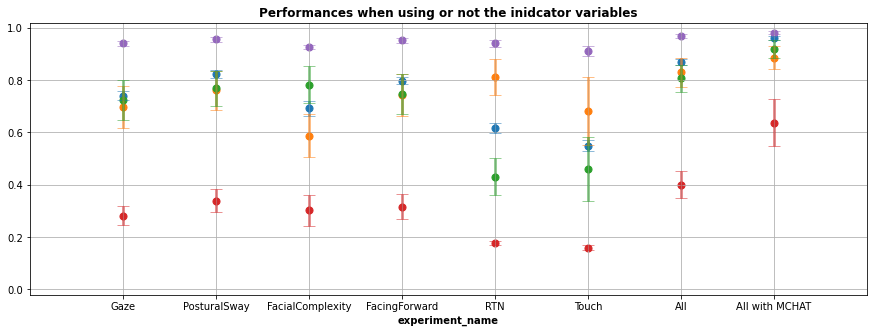

In [13]:
results = results_df_vertical[(results_df_vertical['experiment_name'].str.contains('Multimodal')) & (results_df_vertical['metric_name'].isin(metrics_to_plot))]
results['experiment_name'] = results['experiment_name'].apply(lambda x: x.replace('Multimodal ', ''))
results['experiment_name'] = results['experiment_name'].replace({name: name.replace('-', 'but\n') if '-' in name else 
                                                                 name.replace('but', 'but\n') if 'but' in name else 
                                                                 name.replace('but', 'but\n') for name in results['experiment_name'].unique()})
results['experiment_name'].unique()
results.reset_index(drop=True, inplace=True)
results['relative_score'] = np.nan

results['experiment_name'].unique()
for idx, row in results.iterrows():
    
    baseline_score = results.loc[(results['experiment_name']=='All') & (results['metric_name']==row['metric_name']), 'score'].mean()
    
    results.loc[idx, 'relative_score'] = (row['score']-baseline_score)#/baseline_score*100
order_multimodal = ['All', 'All - Gaze', 'All - RTN', 'All - PosturalSway', 'All - Touch', 'Gaze', 'RTN', 'PosturalSway', 'Touch']
order_multimodal = ['Gaze', 'PosturalSway', 'FacialComplexity', 'FacingForward', 'RTN', 'Touch', 'All', 'All but\n Gaze', 'All but\n PosturalSway', 'All but\n FacialComplexity', 'All but\n FacingForward', 'All but\n RTN', 'All but\n Touch', 'All with MCHAT']
order_multimodal = ['Gaze', 'PosturalSway', 'FacialComplexity', 'FacingForward', 'RTN', 'Touch', 'All', 'All with MCHAT']


condition = 'experiment_name'
plot_scatter_results(results[results['experiment_name'].isin(order_multimodal)], condition, xtickslabels=None, order=order_multimodal, rotate=False, savefig='features_comparison')
    

In [21]:
results.metric_name.unique()

array(['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'NPV'], dtype=object)

In [23]:
results_df_vertical[results_df_vertical['metric_name'].isin( ['AUROC', 'Sensitivity', 'Specificity','PPV', 'PPV-Corr', 'NPV', 'NPV Corr'])].groupby(['experiment_name', 'metric_name']).describe()['score']

count      mean       std       min       25%       50%       75%       max
experiment_name                   metric_name                                                                             
Multimodal All                    AUROC        100.0  0.868660  0.011025  0.846000  0.860750  0.867000  0.878000  0.893000
                                  NPV          100.0  0.969920  0.008057  0.950000  0.964000  0.971500  0.974250  0.988000
                                  NPV Corr     100.0  0.995606  0.001206  0.992649  0.994683  0.995843  0.996296  0.998262
                                  PPV          100.0  0.400990  0.052114  0.271000  0.371750  0.394000  0.432750  0.548000
                                  PPV-Corr     100.0  0.088110  0.017954  0.050000  0.077750  0.085000  0.098250  0.147000
                                  Sensitivity  100.0  0.829890  0.055451  0.694000  0.796000  0.837000  0.857000  0.939000
                                  Specificity  100.0  0.807470  0.052151  0.622000  0.780000  0.811000  0.842000  0.915000
Multimodal All - BlinkRate        AUROC        100.0  0.962430  0.006861  0.947000  0.957000  0.964000  0.968000  0.976000
                                  NPV          100.0  0.981850  0.005461  0.969000  0.978000  0.981000  0.984000  0.993000
                                  NPV Corr     100.0  0.997377  0.000791  0.995535  0.996848  0.997299  0.997713  0.999037
                                  PPV          100.0  0.669350  0.092160  0.495000  0.591250  0.672000  0.754000  0.851000
                                  PPV-Corr     100.0  0.237560  0.078134  0.122000  0.170500  0.225000  0.304000  0.448000
                                  Sensitivity  100.0  0.883950  0.037761  0.796000  0.857000  0.878000  0.898000  0.959000
                                  Specificity  100.0  0.929820  0.031256  0.854000  0.905000  0.934500  0.957000  0.979000
Multimodal All - FacialComplexity AUROC        100.0  0.860330  0.011478  0.832000  0.853750  0.859500  0.866000  0.887000
                                  NPV          100.0  0.969410  0.008103  0.948000  0.964750  0.970000  0.976000  0.986000
                                  NPV Corr     100.0  0.995520  0.001210  0.992216  0.994837  0.995635  0.996443  0.997963
                                  PPV          100.0  0.383870  0.050619  0.272000  0.344250  0.380000  0.408500  0.547000
                                  PPV-Corr     100.0  0.082480  0.016790  0.050000  0.069750  0.080000  0.089250  0.146000
                                  Sensitivity  100.0  0.829660  0.054739  0.673000  0.796000  0.837000  0.878000  0.939000
                                  Specificity  100.0  0.793660  0.053560  0.625000  0.755250  0.803500  0.826000  0.912000
Multimodal All - FacingForward    AUROC        100.0  0.858500  0.012409  0.823000  0.851000  0.856000  0.868000  0.885000
                                  NPV          100.0  0.966150  0.006267  0.951000  0.961000  0.966000  0.970250  0.984000
                                  NPV Corr     100.0  0.995035  0.000944  0.992773  0.994314  0.995031  0.995664  0.997646
                                  PPV          100.0  0.410930  0.047068  0.301000  0.375500  0.412000  0.440000  0.521000
                                  PPV-Corr     100.0  0.091270  0.016236  0.058000  0.078750  0.090500  0.100500  0.134000
                                  Sensitivity  100.0  0.805750  0.042651  0.694000  0.776000  0.806000  0.837000  0.918000
                                  Specificity  100.0  0.822530  0.041575  0.689000  0.795250  0.829000  0.851000  0.896000
Multimodal All - Gaze             AUROC        100.0  0.856310  0.012341  0.825000  0.848750  0.856000  0.864000  0.886000
                                  NPV          100.0  0.965270  0.009124  0.941000  0.958000  0.965000  0.972000  0.983000
                                  NPV Corr     100.0  0.994905  0.001382  0.991191  0.993866  0.994929  0.99589

In [76]:
results.groupby(['experiment_name', 'metric_name']).describe()['score']

count      mean       std    min     25%    50%     75%    max
experiment_name metric_name                                                                
All             AUROC         63.0  0.869587  0.011998  0.846  0.8615  0.870  0.8780  0.893
                NPV           63.0  0.971667  0.007595  0.950  0.9655  0.973  0.9765  0.988
                PPV           63.0  0.387683  0.039369  0.271  0.3680  0.387  0.4100  0.464
                Sensitivity   63.0  0.842651  0.049932  0.694  0.7960  0.857  0.8780  0.939
                Specificity   63.0  0.796190  0.046178  0.622  0.7770  0.802  0.8230  0.878
...                            ...       ...       ...    ...     ...    ...     ...    ...
Touch           AUROC         63.0  0.549206  0.021613  0.497  0.5380  0.549  0.5615  0.599
                NPV           63.0  0.909095  0.015613  0.882  0.8970  0.907  0.9200  0.964
                PPV           63.0  0.159635  0.008354  0.145  0.1525  0.160  0.1635  0.183
                Sensitivity   63.0  0.677714  0.117606  0.490  0.5815  0.694  0.7655  0.959
                Specificity   63.0  0.463825  0.108074  0.165  0.4055  0.454  0.5475  0.622

[80 rows x 8 columns]

In [78]:
results.experiment_name.unique()

array(['All but\n Touch', 'BlinkRate', 'Touch', 'Gaze',
       'All but\n BlinkRate', 'All but\n Gaze', 'All but\n RTN', 'RTN',
       'FacingForward', 'FacialComplexity', 'All but\n PosturalSway',
       'All but\n FacialComplexity', 'All', 'PosturalSway',
       'All but\n FacingForward', 'All with MCHAT'], dtype=object)

# 2) Experiment on the subgroups analysis

**Gathering the results of the experiment on all app features on NT vs Autstic**

In [51]:
from utils import create_autism_df

df = create_autism_df(folder_names = ['multimodal_paper_final'])
pi = df.iloc[0]['y_true'][0].mean()
correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
df['NPV Corr'] = df.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)
#df.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_asd_nt_all_variables.csv', index=False)


100%|██████████| 1001/1001 [06:10<00:00,  2.70it/s]


In [55]:
from utils import compute_performances
performances_df = compute_performances(df)


**Creation of the final model to perfrom the subgroup analysis**

In [56]:
df_subgroup_analysis = deepcopy(performances_df)
df_subgroup_analysis

,name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)",Std - Sensitivity,"Specificity, selectivity or true negative rate (TNR)",Std - Specificity,Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Corrected NPV,Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN,optimal_threshold,num_samples,TN_normalized,TP_normalized,FP_normalized,FN_normalized,N,y_true,y_pred,Hanley_CI
\n(N=377),\n(N=377),0.899,0.622,0.935,0.222,0.953,0.545,0.161,0.712,0.315,0.817,0.513,0.878,0.044,0.808,0.023,0.406,0.088,0.997,0.978,0.122,0.594,0.022,43,265,63,6,0.378,377,70.291777,11.405836,16.710875,1.591512,377,"[0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, ...","[0.001, 1.0, 0.001, 0.775, 0.27, 0.283, 0.177,...",0.030085


**Initialize the result dataframe**

In [62]:
results = None
for i, row in df_subgroup_analysis.iterrows():
    
    y_true = row['y_true']
    y_pred = row['y_pred']
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(row['y_true'])/row['num_samples'], np.sum(row['y_true'][0] == 0), np.sum(row['y_true'][0] == 1))

    
    res = compute_results(y_true, y_pred, optimal_threshold, name="All", title=title)
    if results is not None:
        results = results.append(res)
    else:
        results = res
    

**Ablation per sex**

In [63]:
for sex, sex_encoding in zip(['Male', 'Female'], [0, 1]):#[0,1]):
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(data.df[data.df['sex']==sex_encoding].index)
        
        y_true = row['y_true'][index_subgroup]
        y_pred = row['y_pred'][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=sex, title=title)
        results = results.append(res)

**Ablation per race and ethnicity**

In [64]:
data.df.loc[data.df['race'].isnull(), 'race'] = -1
for race, race_encoding in zip(['White/Caucasian', 'Black/African American', 'Other'], [0,1, 2]):
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(data.df[data.df['race']==race_encoding].index)
        
        y_true = row['y_true'][index_subgroup]
        y_pred = row['y_pred'][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=race, title=title)
        results = results.append(res)
        
    
        
for ethnicity, ethnicity_encoding in zip(['Not Hispanic/Latino', 'Hispanic/Latino'], [0,1]):
    
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(data.df[data.df['ethnicity']==ethnicity_encoding].index)
        
        y_true = row['y_true'][index_subgroup]
        y_pred = row['y_pred'][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=ethnicity, title=title)
        results = results.append(res)    
    

**Ablation per age**

In [65]:
age_bins = [[17, 21], [21, 25], [25, 29], [29, 36], [36, 50]]
age_bins = [[17, 18.5], [18.5, 24], [24, 37]]


data.df['age_bin'] = np.nan
for (low_age, high_age) in age_bins:
    
    age_name = 'Age (Months)\n{}-{}'.format(low_age, high_age)
    data.df.loc[(data.df['age'] >= low_age) & (data.df['age'] < high_age), 'age_bin'] = age_name
    
    
for age_bin in data.df['age_bin'].unique():
    
    for i, row in df_subgroup_analysis.iterrows():
        
        index_subgroup = np.array(data.df[data.df['age_bin']==age_bin].index)
        
        y_true = row['y_true'][index_subgroup]
        y_pred = row['y_pred'][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name=str(age_bin), title=title)
        results = results.append(res)    
    

**Ablation per Mchat results**

In [66]:

for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(data.df[data.df['mchat_final'].isnull()].index)

    y_true = row['y_true'][index_subgroup]
    y_pred = row['y_pred'][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name='No MCHAT', title=title)
    results = results.append(res)    

for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(data.df[data.df['mchat_result'] == 0].index)

    y_true = row['y_true'][index_subgroup]
    y_pred = row['y_pred'][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name='MCHAT Negative',title=title)
    results = results.append(res)    


for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(data.df[data.df['mchat_result'] == 1].index)

    y_true = row['y_true'][index_subgroup]
    y_pred = row['y_pred'][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name='MCHAT Positive', title=title)
    results = results.append(res)    


**Based on Conclusiveness**

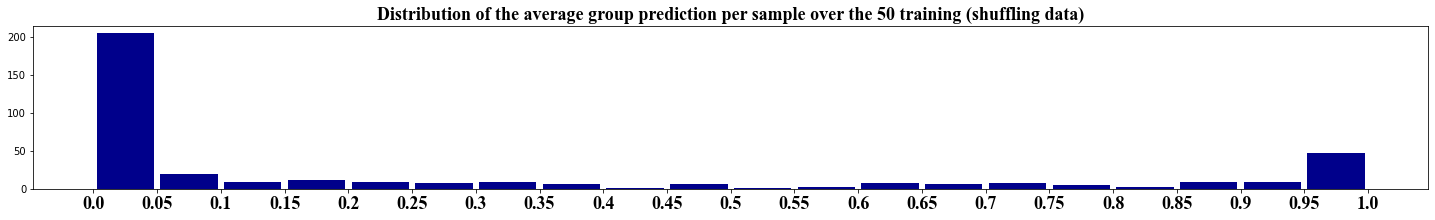

In [69]:


conclusiveness_score  = performances_df.iloc[0]['y_pred']
  
fi(25, 3)
plt.hist(conclusiveness_score, bins=np.arange(0, 1.05, .05), color='darkblue', rwidth = 0.9)
plt.title("Distribution of the average group prediction per sample over the 50 training (shuffling data)", weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.xticks(np.arange(0, 1.05, .05), np.round(np.arange(0, 1.05, .05), 2).astype(str), weight='bold', fontsize=18, **csfont)
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'conclusiveness.png'), dpi=200, bbox_inches = 'tight')
None

# Inconclusive
for th in [0.05, 0.1, 0.15, 0.2]:
    
    for i, row in df_subgroup_analysis.iterrows():
                
        index_subgroup = np.argwhere((conclusiveness_score > th) & (conclusiveness_score< 1-th)).flatten()
        
        y_true = row['y_true'][index_subgroup]
        y_pred = row['y_pred'][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name="Inconclusive ({})".format(th), title=title)
        results = results.append(res)    
        
        
# Conclusive
for th in [0.05, 0.1, 0.15, 0.2]:
    
    for i, row in df_subgroup_analysis.iterrows():
                
        index_subgroup = np.argwhere((conclusiveness_score <= th) | (conclusiveness_score >= 1-th)).flatten()
        
        y_true = row['y_true'][index_subgroup]
        y_pred = row['y_pred'][index_subgroup]
        optimal_threshold = row['optimal_threshold']
        title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))


        res = compute_results(y_true, y_pred, optimal_threshold, name="Conclusive ({})".format(th), title=title)
        results = results.append(res)    

**Based on missing variables**

In [62]:
X  = pd.DataFrame(data._X_train, columns=data.features_name)
dataset = X.copy()

vars = dataset.dtypes.index.values
n_var = dataset.shape[1]

# set up missing data patterns
r = 1 * dataset.isnull()
mdp = np.dot(r, list(map(lambda x: pow(2, x), range(n_var))))
sorted_mdp = sorted(np.unique(mdp))
n_pat = len(sorted_mdp)
correct_mdp = list(map(lambda x: sorted_mdp.index(x), mdp))
data.df["mdp"] = pd.Series(correct_mdp, index=dataset.index)

grouped_missing_features = {k: [v] for k, v in feature_name_mapping.items()}

for mdp in sorted(data.df["mdp"].unique()):
    
    d = deepcopy(data.df[data.df["mdp"] == mdp])
    
    if len(d)/len(data.df)*100 > 5:
        print(mdp, "{:.2f} %".format(len(d)/len(data.df)*100))
        print("\n".join(d[data.features_name].columns[d[data.features_name].isna().any()].tolist()))
mapping_name = {0: "Complete", 
                10: "Only game missing", 
                12: "Game and Delay missing", 
                3: "Only delay missing"}
               # 11: "Game & Delay missing"}

#for mdp_index in mapping_name.keys():
#    d = dataframe[dataframe['mdp']==mdp_index]

for mdp_index in mapping_name.keys():
    for i, row in df_subgroup_analysis.iterrows():

        index_subgroup = np.array(data.df[data.df["mdp"] == mdp_index].index)
        try:

            y_true = row['y_true'][index_subgroup]
            y_pred = row['y_pred'][index_subgroup]
            optimal_threshold = row['optimal_threshold']
            title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

            res = compute_results(y_true, y_pred, optimal_threshold, name= mapping_name[mdp_index],title=title)
            results = results.append(res)    
        except:
            pass



0 48.81 %

2 13.53 %
average_response_to_name_delay
12 19.36 %
pop_rate
std_error
average_length
average_force_applied
14 7.96 %
average_response_to_name_delay
pop_rate
std_error
average_length
average_force_applied


**Results for administrations having a compliance higher than .75**

In [70]:
sample_weight = np.load(os.path.join(DATA_DIR, 'multimodal_paper', 'weight_multimodal.npy'))

In [71]:
for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(np.argwhere(sample_weight >=.75).flatten())

    y_true = row['y_true'][index_subgroup]
    y_pred = row['y_pred'][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name= 'Conclusive\nAdministrations',title=title)
    results = results.append(res)    


for i, row in df_subgroup_analysis.iterrows():

    index_subgroup = np.array(np.argwhere(sample_weight < .75).flatten())

    y_true = row['y_true'][index_subgroup]
    y_pred = row['y_pred'][index_subgroup]
    optimal_threshold = row['optimal_threshold']
    title = "{:.2f} % of the dataset ({} NT - {} autistic)".format(100*len(y_true)/row['num_samples'], np.sum(y_true == 0), np.sum(y_true== 1))

    res = compute_results(y_true, y_pred, optimal_threshold, name= 'Inconclusive\nAdministrations',title=title)
    results = results.append(res)    

## Analysis of the results

**Creation of the vertical dataframe**

In [82]:
results['correction_factor'] = results.apply(lambda x: (np.mean(x['y_true'])*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-np.mean(x['y_true']))), axis=1)
results['NPV-Corr'] = results.apply(lambda x: (x['correction_factor']*x['TN'])/(x['correction_factor']*x['TN']+x['FN']+1e-5), axis=1)

final_results = deepcopy(results)
final_results['y_true'] = list(final_results['y_true'])
final_results['y_pred'] = list(final_results['y_pred'])

#final_results.to_csv('/home01/sam/notes_on_stats/doc/results_dataframe/df_asd_nt_subgroups.csv', index=False)


final_results.reset_index(inplace=True)
final_results.rename(columns={'Sensitivity, recall, hit rate, or true positive rate (TPR)':'Sensitivity', 
                       'Specificity, selectivity or true negative rate (TNR)':'Specificity', 
                       'Corrected Precision or positive predictive value (PPV)':'PPV-Corr', 
                       'Precision or positive predictive value (PPV)': 'PPV', 
                              'Negative predictive value (NPV)': 'NPV'
                              
                       }, inplace=True)

final_results.rename(columns={'index': 'subgroup'}, inplace=True)
final_results['subgroup_name'] = final_results['subgroup'].apply(lambda x: x.split('\n')[0] if x.split('\n')[0]!='Age' else x.split('\n')[0] + '\n' + x.split('\n')[1])


results_vertical = pd.DataFrame(columns = ['subgroup', 'score', 'metric_name'])#, 'TP', 'TN', 'FP', 'FN', 'N'])

metrics_of_interest =['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'PPV-Corr', 'NPV', 'NPV-Corr', 'Std - Sensitivity', 'Std - Specificity']
metrics_to_plot = ['AUROC', 'Sensitivity', 'Specificity', 'PPV', 'PPV-Corr', 'NPV', 'NPV-Corr', 'Std - Sensitivity', 'Std - Specificity']
metrics_of_interest =[ 'Std - Sensitivity', 'Std - Specificity']

for _, experiment_row in final_results.iterrows():
    
    pi = row['y_true'][0].mean()
    correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))

    
    for metric in metrics_of_interest:
        
        results_vertical = results_vertical.append(pd.DataFrame({'subgroup':experiment_row['subgroup'], 
                                                                       'score':experiment_row[metric], 
                                                                       'metric_name':metric,
                                                                       'TP':experiment_row['TP'], 
                                                                       'TN':experiment_row['TN'], 
                                                                       'FP':experiment_row['FP'], 
                                                                       'FN':experiment_row['FN'], 
                                                                       'N': experiment_row['N'], 
                                                                       'Hanley_CI': experiment_row['Hanley_CI'],
                                                                       'y_true': [experiment_row['y_true']],
                                                                       'y_pred': [experiment_row['y_pred']]
                                                                      }, index=[0]))
        
results_vertical.reset_index(drop=True, inplace=True)
results_vertical['subgroup_name'] = results_vertical['subgroup'].apply(lambda x: x.split('\n')[0] if x.split('\n')[0]!='Age' else x.split('\n')[0] + '\n' + x.split('\n')[1])
results_vertical['N'] = results_vertical['N'].astype(int)
results_vertical['subgroup_raw'] = results_vertical['subgroup'].apply(lambda x: "\n".join(x.split('\n')[:-1]))

In [74]:
results_vertical['subgroup_raw'].unique()

array(['All', 'Male', 'Female', 'White/Caucasian',
       'Black/African American', 'Other', 'Not Hispanic/Latino',
       'Hispanic/Latino', 'Age (Months)\n24-37', 'Age (Months)\n18.5-24',
       'Age (Months)\n17-18.5', 'No MCHAT', 'MCHAT Negative',
       'MCHAT Positive', 'Inconclusive (0.05)', 'Inconclusive (0.1)',
       'Inconclusive (0.15)', 'Inconclusive (0.2)', 'Conclusive (0.05)',
       'Conclusive (0.1)', 'Conclusive (0.15)', 'Conclusive (0.2)',
       'Conclusive\nAdministrations', 'Inconclusive\nAdministrations'],
      dtype=object)

**Plot results per subgroups**

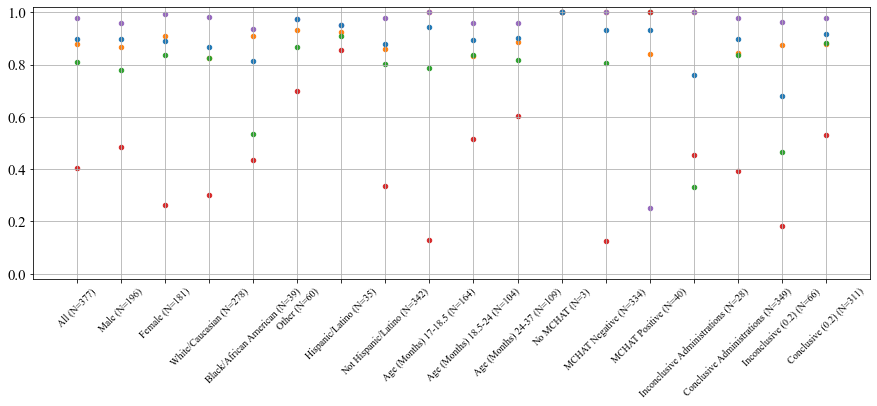

In [68]:
colors = plt.get_cmap('tab10')(np.arange(0,20))
rotate=1
savefig="Subgroups_analysis"
plt.rcParams["font.family"] = "Times New Roman"

condition = 'subgroup_raw'

order = ['All', 'Male', 'Female', 
         'White/Caucasian',
       'Black/African American', 'Other',
       'Hispanic/Latino',  'Not Hispanic/Latino',
         'Age (Months)\n17-18.5','Age (Months)\n18.5-24', 'Age (Months)\n24-37', 
        'No MCHAT', 'MCHAT Negative',
       'MCHAT Positive', 
        # 'Complete', 'Only game missing', 'Game and Delay missing', 'Only delay missing',
       'Inconclusive\nAdministrations', 'Conclusive\nAdministrations', 
         'Inconclusive (0.2)','Conclusive (0.2)']


xtickslabel = []
fig = plt.figure(figsize=(15, 5));ax = plt.gca()
# loop over the curves (i.e. the metrics to be plotted)
for j, metric_name in enumerate([ 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'AUROC']):
    
    color = colors[j+1] if j!= 4 else colors[0]
    # loop over the x ticks  (i.e. the condition that is varying)
    for i, condition_value in enumerate(order):

        plt.errorbar([i], 
                     results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['score'].mean(),
                     yerr=results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['score'].std(), 
                     fmt='',
                     ecolor=color,
                    # ecolor=color,
                     alpha=.6, 
                     capthick=1,
                     elinewidth=1,
                     capsize=6)
        plt.scatter([i], 
                     results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['score'].mean(),
                     marker='o',
                     s=20,
                     label=metric_name if i==0 else None, color=color)
        if j ==0:
            xtickslabel.append(results_vertical[(results_vertical['metric_name']==metric_name) &
                                (results_vertical[condition]==condition_value)]['subgroup'].iloc[0].replace("\n", " "))

plt.grid(); #plt.title("Performances when using or not the inidcator variables", weight='bold')
#plt.ylabel(metric_name, weight='bold');
#plt.xlabel(condition, weight='bold');
plt.xlim([-1, len(xtickslabel)]); plt.ylim([-0.02, 1.02])
plt.xticks(np.arange(len(xtickslabel)), xtickslabel, rotation=45 if rotate else 0, fontsize=10);
plt.yticks( fontsize=15);

#plt.legend(prop={'size':20})
plt.savefig(os.path.join(ROOT_DIR, 'figures', 'subgroup_results.png'), dpi=200, bbox_inches = 'tight')

In [83]:
pd.set_option('display.max_rows', None)
results_vertical.groupby(['subgroup', 'metric_name']).describe()

score                                                  TP                                            TN                                                  FP                                            FN                                       N                                               Hanley_CI                                                                
                                                        count   mean std    min    25%    50%    75%    max count  mean std   min   25%   50%   75%   max count   mean std    min    25%    50%    75%    max count  mean std   min   25%   50%   75%   max count mean std  min  25%  50%  75%  max count   mean std    min    25%    50%    75%    max     count      mean std       min       25%       50%       75%       max
subgroup                              metric_name                                                                                                                                                                                                                                                                                                                                                                                
Age (Months)\n17-18.5\n(N=164)        Std - Sensitivity   1.0  0.000 NaN  0.000  0.000  0.000  0.000  0.000   1.0   5.0 NaN   5.0   5.0   5.0   5.0   5.0   1.0  125.0 NaN  125.0  125.0  125.0  125.0  125.0   1.0  34.0 NaN  34.0  34.0  34.0  34.0  34.0   1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0   1.0  164.0 NaN  164.0  164.0  164.0  164.0  164.0       1.0  0.071399 NaN  0.071399  0.071399  0.071399  0.071399  0.071399
                                      Std - Specificity   1.0  0.028 NaN  0.028  0.028  0.028  0.028  0.028   1.0   5.0 NaN   5.0   5.0   5.0   5.0   5.0   1.0  125.0 NaN  125.0  125.0  125.0  125.0  125.0   1.0  34.0 NaN  34.0  34.0  34.0  34.0  34.0   1.0  0.0 NaN  0.0  0.0  0.0  0.0  0.0   1.0  164.0 NaN  164.0  164.0  164.0  164.0  164.0       1.0  0.071399 NaN  0.071399  0.071399  0.071399  0.071399  0.071399
Age (Months)\n18.5-24\n(N=104)        Std - Sensitivity   1.0  0.095 NaN  0.095  0.095  0.095  0.095  0.095   1.0  15.0 NaN  15.0  15.0  15.0  15.0  15.0   1.0   72.0 NaN   72.0   72.0   72.0   72.0   72.0   1.0  14.0 NaN  14.0  14.0  14.0  14.0  14.0   1.0  3.0 NaN  3.0  3.0  3.0  3.0  3.0   1.0  104.0 NaN  104.0  104.0  104.0  104.0  104.0       1.0  0.050950 NaN  0.050950  0.050950  0.050950  0.050950  0.050950
                                      Std - Specificity   1.0  0.047 NaN  0.047  0.047  0.047  0.047  0.047   1.0  15.0 NaN  15.0  15.0  15.0  15.0  15.0   1.0   72.0 NaN   72.0   72.0   72.0   72.0   72.0   1.0  14.0 NaN  14.0  14.0  14.0  14.0  14.0   1.0  3.0 NaN  3.0  3.0  3.0  3.0  3.0   1.0  104.0 NaN  104.0  104.0  104.0  104.0  104.0       1.0  0.050950 NaN  0.050950  0.050950  0.050950  0.050950  0.050950
Age (Months)\n24-37\n(N=109)          Std - Sensitivity   1.0  0.060 NaN  0.060  0.060  0.060  0.060  0.060   1.0  23.0 NaN  23.0  23.0  23.0  23.0  23.0   1.0   68.0 NaN   68.0   68.0   68.0   68.0   68.0   1.0  15.0 NaN  15.0  15.0  15.0  15.0  15.0   1.0  3.0 NaN  3.0  3.0  3.0  3.0  3.0   1.0  109.0 NaN  109.0  109.0  109.0  109.0  109.0       1.0  0.041724 NaN  0.041724  0.041724  0.041724  0.041724  0.041724
                                      Std - Specificity   1.0  0.043 NaN  0.043  0.043  0.043  0.043  0.043   1.0  23.0 NaN  23.0  23.0  23.0  23.0  23.0   1.0   68.0 NaN   68.0   68.0   68.0   68.0   68.0   1.0  15.0 NaN  15.0  15.0  15.0  15.0  15.0   1.0  3.0 NaN  3.0  3.0  3.0  3.0  3.0   1.0  109.0 NaN  109.0  109.0  109.0  109.0  109.0       1.0  0.041724 NaN  0.041724  0.041724  0.041724  0.041724  0.041724
All\n(N=377)                          Std - Sensitivity   1.0  0.041 NaN  0.041  0.041  0.041  0.041  0.041   1.0  43.0 NaN  43.0  43.0  43.0  43.0  43.0   1.0  265.0 NaN  265.0  265.0  265.0  265.0  265.0   1.0  63.0 NaN  63.0  63.0  63.0  63.0  63.0   1.0  6.0 NaN  6.0  6.0  6.0  6.0  6.0   

In [39]:
df

from utils import create_autism_df, compute_performances, bootstrap_sensitivity_specificity
performances_df = compute_performances(df)
 
y_pred = performances_df.iloc[0]['y_pred']
y_true = performances_df.iloc[0]['y_true']
optimal_threshold = performances_df.iloc[0]['optimal_threshold']
bootstrap_sensitivity_specificity(y_true, y_pred, optimal_threshold)

Average Sensitivity: 0.867 +/- 0.049
Average Specificity: 0.808 +/- 0.023


# Plot AUROC for certain experiemnts

In [105]:
from utils import create_autism_df


#d1 = df[df['experiment_name']=='Multimodal All'].sort_values('AUROC').iloc[25:26][columns_of_interest]
d1 = compute_performances(df[df['experiment_name'] == 'Multimodal All'])
d1['name'] = 'All'
sd1 = d1['Hanley_CI'].item()

#d2 = df[df['experiment_name']=='Multimodal All with MCHAT'].sort_values('AUROC').iloc[25:26][columns_of_interest]
d2 = compute_performances(df[df['experiment_name'] == 'Multimodal All with MCHAT'])

d2['name'] = 'All+MCHAT R/F'
sd2 = d2['Hanley_CI'].item()


df_nt_ddld = create_autism_df(folder_names = ['multimodal_paper_final_nt_ddld'])#'13_november_bis'])#'November 2022'])
#pi = df_nt_ddld.iloc[0]['y_true'][0].mean()
#correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
#df_nt_ddld['NPV Corr'] = df_nt_ddld.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)

d3 = compute_performances(df_nt_ddld)
d3['name'] = 'LD-DD vs NT'
sd3 = d3['Hanley_CI'].item()



df_nt_ddld_asd = create_autism_df(folder_names = ['multimodal_paper_final_nt_ddld_asd'])#'13_november_bis'])#'November 2022'])
#pi = df_nt_ddld_asd.iloc[0]['y_true'][0].mean()
#correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
#df_nt_ddld_asd['NPV Corr'] = df_nt_ddld_asd.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)
d4 = compute_performances(df_nt_ddld_asd)
d4['name'] = 'Autistic+LD/DD vs NT'
sd4 = d4['Hanley_CI'].item()

#d4 = df_nt_ddld_asd.sort_values('AUROC').iloc[25:26][columns_of_interest]
#da = compute_performances(df_nt_ddld)
#sd4 = df_nt_ddld_asd['AUROC'].std()
#d4['name'] = 'Autistic+LD/DD vs NT'

df_asd_nasd = create_autism_df(folder_names = ['multimodal_paper_final_asd_nasd'])#'13_november_bis'])#'November 2022'])
#pi = df_nt_ddld_asd.iloc[0]['y_true'][0].mean()
#correction_factor = (pi*(1-REFERENCE_IMBALANCE_RATIO))/(REFERENCE_IMBALANCE_RATIO*(1-pi))
#df_nt_ddld_asd['NPV Corr'] = df_nt_ddld_asd.apply(lambda x: (correction_factor*x['TN'])/(correction_factor*x['TN']+x['FN']), axis=1)

#d4 = df_nt_ddld_asd.sort_values('AUROC').iloc[25:26][columns_of_interest]
#sd4 = df_nt_ddld_asd['AUROC'].std()
#d4['name'] = 'Autistic+LD/DD vs NT'
d5 = compute_performances(df_asd_nasd)
d5['name'] = 'Autisticvs Non-autistic'
sd5 = d5['Hanley_CI'].item()

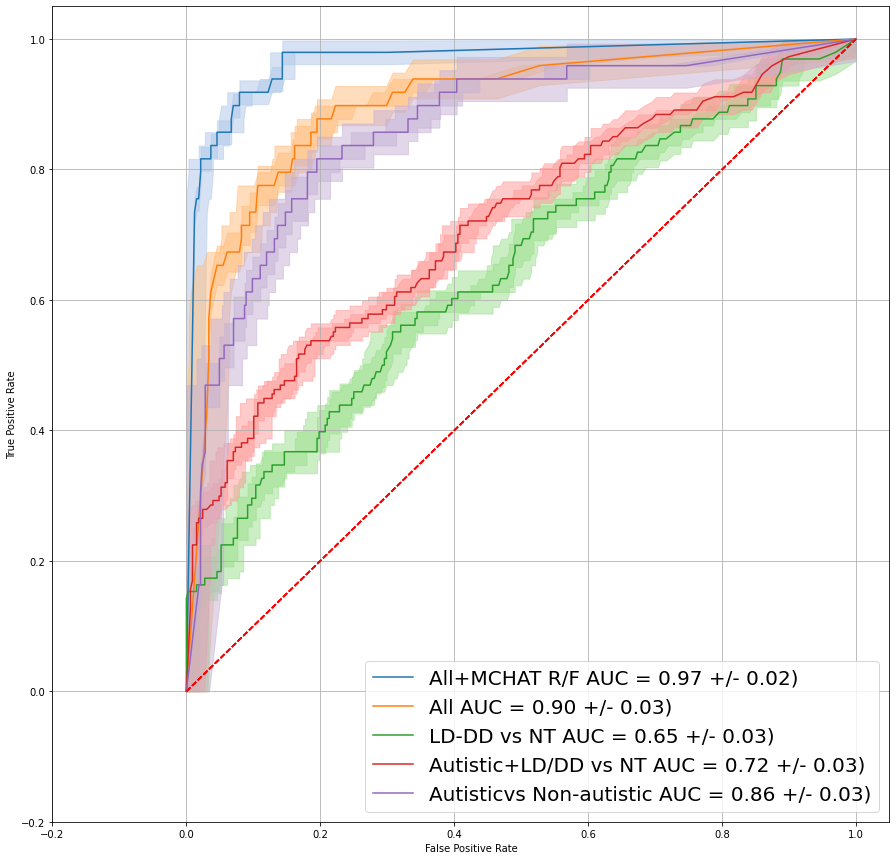

In [121]:
colors = plt.get_cmap('tab20')(np.arange(0,20))
fig, axes = plt.subplots(1, 1, figsize=(15, 15));axes = [axes]
name='All'
fprs = []
tprs  =[] 
i=0

for i, (dataframe, sd) in enumerate(zip([d2, d1, d3, d4, d5], [sd1, sd2, sd3, sd4, sd5])):
            
    row = dataframe.iloc[0]

    # ROC CURVE
    y_true = row['y_true']
    y_pred = row['y_pred']
    


    fpr, tpr, thresholds = roc_curve(y_true, y_pred); roc_auc = auc(fpr, tpr)
    
    sd = compute_SD(roc_auc, np.sum(y_true==1), np.sum(y_true==0))

    axes[0].plot(fpr, tpr, '-', lw=1.5, color=colors[2*i],  label='{} AUC = {:.2f} +/- {:.2f})'.format(row['name'], roc_auc, sd))
    axes[0].plot([0, 1], [0, 1], color='red', lw=1.5, linestyle='--')
    axes[0].set_xlim([0.0, 1.0]); axes[0].set_ylim([0.0, 1.05]);
    axes[0].set_xlabel('False Positive Rate'); axes[0].set_ylabel('True Positive Rate')

    tprs_upper = np.minimum(tpr + sd, 1);tprs_lower = np.maximum(tpr - sd, 0)
    axes[0].fill_between(fpr, tprs_lower, tprs_upper, color=colors[2*i + 1], alpha=.5)

    fpr_upper = np.minimum(fpr + sd, 1);fpr_lower = np.maximum(fpr - sd, 0)
    axes[0].fill_betweenx(tpr, fpr_lower, fpr_upper, color=colors[2*i + 1], alpha=.5)

    #idx_threshold = np.argmin(np.abs(thresholds - row['optimal_threshold']))
    #axes[0].scatter(fpr[idx_threshold], tpr[idx_threshold], color='tab:red', s=100, label="Optimal F2" if i==len(comparisons)-1 else None)

    axes[0].grid('on'); #axes[0].axis('off')
    axes[0].set_xlim(-.2, 1.05)
    axes[0].set_ylim(-.2, 1.05)
    axes[0].legend(loc='lower right', prop={'size':20})
    #axes[0].set_title(comparisons_name, weight='bold', fontsize=18)
plt.savefig(os.path.join(ROOT_DIR, 'figures_final', 'AUROC.png'), dpi=200, bbox_inches = 'tight')

In [ ]:
d1